# Trabalho prático Visão por Computador

## Group 13  <br>
Nelson José Marques Martins Almeida pg52697 <br>
Carlos Gustavo Silva Pereira pg53723

## Enunciado do trabalho 1 - grupo (2-3 elementos)
Neste trabalho pretende-se explorar modelos de deep learning aplicados ao dataset GTSRB (dataset alemão de sinais de trânsito) para obter o melhor resultado possível em termos de accuracy no dataset de teste (o melhor resultado publicado é 99.82%). <br>
O trabalho divide-se em duas partes:
Numa primeira parte é suposto treinar modelos aplicando "data augmentation", tanto em pré-processamento como dinâmico. Pretende-se nesta primeira parte explorar os filtros e métodos de processamento de imagem e avaliar o impacto dos mesmos no desempenho final da rede. Parte da avaliação será ditada pelo uso das técnicas de processamento de imagem utilizadas.  Devem ser treinadas vários modelos, com "data augmentation" diferentes, e ser realizada uma análise aos resultados obtidos.
Numa segunda fase é pretendido estudar o potencial de utilizar ensembles de redes. As redes que farão parte do ensemble são as treinadas na primeira fase.
Dataset alemão:
Imagens para treino (ZIP)https://www.di.uminho.pt/~arf/storage/dl/train_images.zip
Imagens para teste (ZIP)https://www.di.uminho.pt/~arf/storage/dl/test_images.zip
Para além do notebook (ou scripts python avulsas) pretende-se um pequeno relatório que descreva as opções tomadas e apresente os testes realizados. O notebook ou as scripts também devem ser devidamente comentadas.

In [1]:
%pip install torch torchvision torchaudio torchinfo matplotlib numpy tqdm requests pandas seaborn scikit-learn opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:

# Lets import the needed dependencies
import torch
import torchvision
from torchvision.transforms import v2

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time
import datetime

# importing a module with utilities for displaying stats and data
import sys
import os

from tqdm import tqdm
import requests
import random

# Switch to the path
sys.path.append('./util/')

#Lets import the auxiliary files
import vcpi_util
from vcpi_util import Early_Stopping
from vcpi_util import *
from Models import *
from SyntheticDataGeneration import *


DEVICE  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Available device: {DEVICE}")
print(torch.cuda.is_available())


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available device: cpu
False


In [2]:
# Lets download the needed images if they are not already downloaded
if not os.path.exists(f'data'):
    os.makedirs(f'data')

if not os.path.exists(f"data/train"):
    print("Downloading train images...")
    if "train_images.zip" not in os.listdir("data/"): requests.get("https://www.di.uminho.pt/~arf/storage/dl/train_images.zip")
    print("Unziping train images...")
    os.system(f"unzip data/train_images.zip -d data/")
    #os.system("rm train_images.zip")

if not os.path.exists(f"data/test"):
    print("Downloading test images...")
    if "test_images.zip" not in os.listdir("data/"): requests.get("https://www.di.uminho.pt/~arf/storage/dl/test_images.zip")
    print("Unziping testing images...")
    os.system(f"unzip data/test_images.zip -d data/")
    #os.system("rm test_images.zip")

if not os.path.exists(f"data/German_Templates") and "German_Templates.zip" in os.listdir("data"):
  print("Extractig template images...")
  os.system(f"unzip data/German_Templates.zip -d data/")
  #os.system("rm German_Templates.zip")

if not os.path.exists(f"data/SyntheticData") and "SyntheticData.zip" in os.listdir("data"):
  print("Extractig Synthetic images...")
  os.system(f"unzip data/SyntheticData.zip -d data/")
  #os.system("rm German_Templates.zip")

print("Data downloaded and extracted successfully!")

Data downloaded and extracted successfully!


In [3]:
#Lets define the paths to store the images
PATH_TRAINING_SET = "./data/train/Final_Training/Images/"
PATH_TEST_SET = "./data/train/Final_Training/Images/"
PATH_SYNTHETIC_SET = "./data/SyntheticData/"
PATH_TEMPLATES = "./data/German_Templates/"

In [4]:
#Lets generate synthetic data to enhance the training data
# The synthetic data will be generated using templates for the signals in the dataset
syntheticDataGenerator = SyntheticDataGeneration(
    templateImagesPath=PATH_TEMPLATES,
    syntheticDataPath=PATH_SYNTHETIC_SET,
    trainingImagesPath=PATH_TRAINING_SET
    )

syntheticDataGenerator.generate()

Synthetic data for signal 0.png already generated, skipping...
Synthetic data for signal 1.png already generated, skipping...
Synthetic data for signal 10_0.png already generated, skipping...
Synthetic data for signal 10_1.png already generated, skipping...
Synthetic data for signal 11.png already generated, skipping...
Synthetic data for signal 12_0.png already generated, skipping...
Synthetic data for signal 12_1.png already generated, skipping...
Synthetic data for signal 13.png already generated, skipping...
Synthetic data for signal 14.png already generated, skipping...
Synthetic data for signal 15.png already generated, skipping...
Synthetic data for signal 16.png already generated, skipping...
Synthetic data for signal 17.png already generated, skipping...
Synthetic data for signal 18.png already generated, skipping...
Synthetic data for signal 19.png already generated, skipping...
Synthetic data for signal 2.png already generated, skipping...
Synthetic data for signal 20.png al

In [4]:
# Lets load the data
import torchvision.transforms.functional


img_size = 32
#But first lets define transformations to apply to the images
#For all transformations we will use the function RandomEqualize to equalize the histograms of the images

transformsBase = v2.Compose([
    v2.ToImage(),
    v2.Resize((img_size, img_size)),
    v2.ToDtype(torch.float32, scale=True)
])

transformsBaseGray = v2.Compose([
    v2.ToImage(),
    v2.Grayscale(),
    v2.Resize((img_size, img_size)),
    v2.ToDtype(torch.float32, scale=True)
])

transformsColorJitter = v2.Compose([
    v2.ToImage(),
    v2.Resize((img_size, img_size)),
    v2.RandomPhotometricDistort(p=0.5),
    v2.ToDtype(torch.float32, scale=True)
])

transformsRandomErasing = v2.Compose([
    v2.ToImage(),
    v2.Resize((img_size, img_size)),
    v2.RandomErasing(p=1, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
    v2.ToDtype(torch.float32, scale=True)
])

transformsRandomErasingColorJitter = v2.Compose([
    v2.ToImage(),
    v2.Resize((img_size, img_size)),
    v2.RandomPhotometricDistort(p=0.5),
    v2.RandomErasing(p=1, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
    v2.
    v2.ToDtype(torch.float32, scale=True)
])

transformatinsRandomErasingGray = v2.Compose([
    v2.ToImage(),
    v2.Grayscale(),
    v2.Resize((img_size, img_size)),
    v2.RandomErasing(p=1, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
    v2.ToDtype(torch.float32, scale=True)
])

#transformations = [transform1, transform2, transform3]
#For the training data we will use the training images plus the synthetic data

train_data = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform=transformsRandomErasingColorJitter)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

synthetic_data = torchvision.datasets.ImageFolder(root=PATH_SYNTHETIC_SET, transform=transformsRandomErasingColorJitter)
synthetic_loader = torch.utils.data.DataLoader(synthetic_data, batch_size=32, shuffle=True)

#Lets merge the training and synthetic data
train_data = torch.utils.data.ConcatDataset([train_data, synthetic_data])
#Lets merge the labels of the training and synthetic data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
train_data = train_data.datasets[0].classes

#For the test data we will use the test images
test_data = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform=v2.Compose([
    v2.ToImage(),
    v2.Resize((img_size, img_size)),
    v2.ToDtype(torch.float32, scale=True)
    ]))

test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

#Lets equalize the histograms of the images

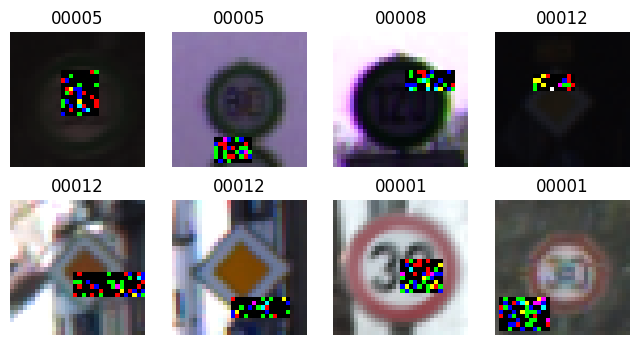

<Figure size 640x480 with 0 Axes>

In [37]:
#Lets see some of the loaded images
labels = next(iter(train_loader))


vcpi_util.show_images(2,4, labels[0], labels[1], train_data)

In [ ]:
target_list = []

for images, targets in train_loader:

    target_list.extend(targets)

vcpi_util.show_histogram(target_list, train_data)

Temos o mesmo número de imagens em todos os sinais

De forma a averiguarmos se as imagens sintéticas trazem alguma vantagem vamos correr um benchmark e treinar uma rede apenas com os sinais originais com as transformações e outra com os dados aumentados com os sinais sintéticos

Para o benchmark vamos usar o mesmo dataset de validação para os dois

In [48]:
BATCH_SIZE = 32

train_noaugmentation_notransforms = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform=transformsBase)
train_loader_noaugmentation_notransforms = torch.utils.data.DataLoader(train_noaugmentation_notransforms, batch_size=BATCH_SIZE, shuffle=True)

train_noaugmentation = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform=transformsRandomErasingColorJitter)
train_loader_noaugmentation = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

synthetic_data = torchvision.datasets.ImageFolder(root=PATH_SYNTHETIC_SET, transform=transformsRandomErasingColorJitter)
synthetic_loader = torch.utils.data.DataLoader(synthetic_data, batch_size=BATCH_SIZE, shuffle=True)

#Lets merge the training and synthetic data
train_augmented = torch.utils.data.ConcatDataset([train_noaugmentation, synthetic_data])
#Lets merge the labels of the training and synthetic data
train_augmented_loader = torch.utils.data.DataLoader(train_augmented, batch_size=BATCH_SIZE, shuffle=True)
train_augmented = train_augmented.datasets[0]

# Vamos dar split em 80 20 dos dados de treino originais para termos um dataset de validação
train_noaugmentation_sub, val_sub = torch.utils.data.random_split(train_noaugmentation, [int(0.8*len(train_noaugmentation)), int(0.2*len(train_noaugmentation))])
train_noaugmentation_sub_loader = torch.utils.data.DataLoader(train_noaugmentation_sub, batch_size = 32, shuffle = True)
val_sub_loader = torch.utils.data.DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=True)

#For the test data we will use the test images
test_data = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform=v2.Compose([
    v2.ToImage(),
    v2.Resize((img_size, img_size)),
    v2.ToDtype(torch.float32, scale=True)
    ]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

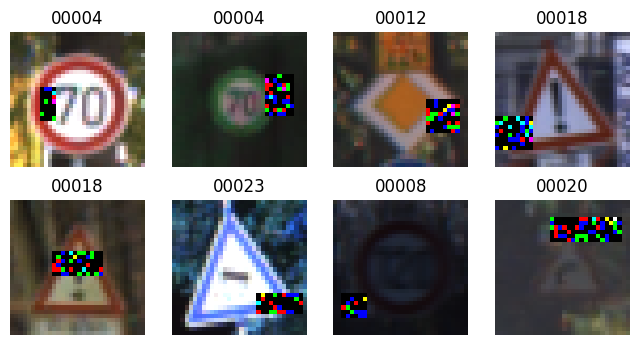

<Figure size 640x480 with 0 Axes>

In [57]:
#Lets see some of the raw training data
labels = next(iter(train_augmented_loader))


vcpi_util.show_images(2,4, labels[0], labels[1], train_augmented.classes)

In [ ]:
#Lets plot some of the synthetic augmented data
labels = next(iter(train_augmented_loader))

vcpi_util.show_images(2,4, labels[0], labels[1], train_augmented)

In [ ]:
#Lets plot some of the raw test data
labels = next(iter(test_loader))

vcpi_util.show_images(2,4, labels[0], labels[1], test_data)

Vamos ver os dados em cada dataset

In [ ]:
# Imagens no dataset sem data augmentation
target_list = []

for _, targets in train_noaugmentation_sub_loader:
    target_list.extend(targets)

vcpi_util.show_histogram(target_list, train_data)

Counter({32: 2451, 16: 2451, 30: 2451, 31: 2451, 26: 2451, 34: 2451, 37: 2451, 39: 2451, 36: 2451, 33: 2451, 27: 2451, 29: 2451, 8: 2450, 15: 2450, 21: 2450, 38: 2450, 6: 2450, 7: 2450, 11: 2450, 24: 2450, 1: 2450, 9: 2450, 5: 2450, 40: 2450, 17: 2450, 0: 2450, 13: 2450, 20: 2450, 18: 2450, 19: 2450, 12: 2450, 23: 2450, 2: 2450, 25: 2450, 3: 2450, 41: 2450, 22: 2450, 42: 2450, 10: 2450, 35: 2450, 14: 2450, 4: 2450, 28: 2248})


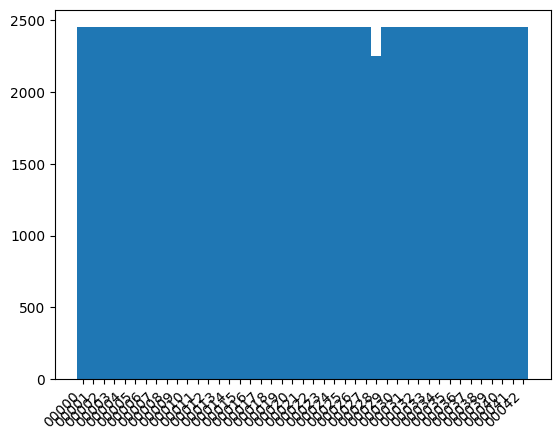

In [11]:
#Imagens no dataset com data augmentation
target_list = []

for _, targets in train_augmented_loader:

    target_list.extend(targets)

vcpi_util.show_histogram(target_list, train_data)

Counter({1: 448, 2: 420, 4: 404, 12: 381, 5: 355, 3: 292, 7: 286, 10: 265, 25: 231, 8: 228, 18: 213, 9: 177, 13: 153, 6: 89, 23: 85, 20: 73, 11: 69, 22: 67, 21: 56, 24: 55, 42: 48, 14: 46, 41: 45, 40: 42, 0: 40, 19: 39, 17: 24, 16: 19, 26: 18, 15: 12, 35: 8, 31: 7, 33: 6, 30: 6, 38: 5, 37: 4, 28: 4, 27: 3, 29: 3, 39: 1, 34: 1, 36: 1})


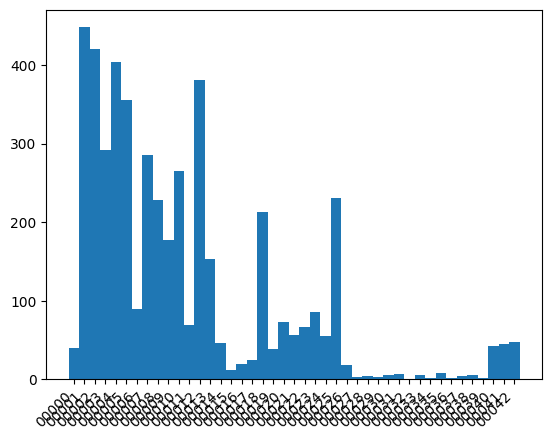

In [10]:
#Imagens no dataset de validação
target_list = []

for _, targets in val_sub_loader:

    target_list.extend(targets)

vcpi_util.show_histogram(target_list, train_data)

Vamos então definir uma rede neuronal convulocional para o nosso modelo.

Vamos definir funções auxiliares como early stopping e schedulers

In [9]:

#TODO: Permitir que seja passado um optimizer pelo utilizador
class Scheduler():
  def __init__(self, model, T_max = 10, eta_min=0.000001, num_epochs = 10):
    self.scheduling_optimizer = torch.optim.Adam(model.parameters())

    self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.scheduling_optimizer, T_max=T_max, eta_min=eta_min)

    lrs = []

    for _ in range(num_epochs):
        self.scheduler.step()
        lrs.append(self.scheduling_optimizer.param_groups[0]['lr'])


# --------------------- Modelo com os dados originais ---------------------

In [10]:
#Vamos fazer um teste sem aplicar nenhuma transformação aos dados de treino
EPOCHS = 200

model_I_vanilla = Conv_I(len(train_noaugmentation_notransforms)).to(DEVICE)
optimizer_I = torch.optim.Adam(model_I_vanilla.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_I, mode='min', factor=0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()
early_stopping = Early_Stopping(9)
model_I_CNN_summary = torchinfo.summary(model_I_vanilla, input_size=(BATCH_SIZE, 3, img_size, img_size))
#Vamos ver a arquitetura da rede
print(model_I_CNN_summary)

Layer (type:depth-idx)                   Output Shape              Param #
Conv_I                                   [32, 23645]               --
├─Conv2d: 1-1                            [32, 16, 30, 30]          448
├─BatchNorm2d: 1-2                       [32, 16, 30, 30]          32
├─ReLU: 1-3                              [32, 16, 30, 30]          --
├─Conv2d: 1-4                            [32, 32, 28, 28]          4,640
├─BatchNorm2d: 1-5                       [32, 32, 28, 28]          64
├─ReLU: 1-6                              [32, 32, 28, 28]          --
├─MaxPool2d: 1-7                         [32, 32, 14, 14]          --
├─Conv2d: 1-8                            [32, 48, 12, 12]          13,872
├─BatchNorm2d: 1-9                       [32, 48, 12, 12]          96
├─ReLU: 1-10                             [32, 48, 12, 12]          --
├─Conv2d: 1-11                           [32, 48, 10, 10]          20,784
├─BatchNorm2d: 1-12                      [32, 48, 10, 10]          96
├─R

In [11]:
save_prefix="model_I_noaugmentation_notransforms"
path_name="model_I_noaugmentation_notransforms"
history_I_vanilla, path_name = train(DEVICE, model_I_vanilla, train_noaugmentation_notransforms, train_loader_noaugmentation_notransforms,val_sub, val_sub_loader, EPOCHS, loss_fn, optimizer_I, scheduler, early_stopping, save_prefix, path_name)
torch.save(model_I_vanilla.state_dict(), f"models/{path_name}/{save_prefix}_best.pth")

Epoch: 0; Acc = 0.0000; Val_loss = 0; Vall_acc: 0; Time: 0.0000:   0%|          | 0/200 [00:00<?, ?it/s]c:\Users\ruben\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch: 0; Acc = 0.0000; Val_loss = 0; Vall_acc: 0; Time: 0.0000:  14%|█▍        | 28/200 [12:11<1:14:56, 26.14s/it]


==> Training finished in 25.074697494506836 minutes
Training stats: 100.0 accuracy | 89.2154769897461 validation accuracy | 83.6394271850586 loss


In [12]:
#Vamos avaliar o modelo 
best_train = np.asarray(history_I_vanilla['accuracy']).argmax()
best_val = np.asarray(history_I_vanilla['val_accuracy']).argmax()
print(f"Best train accuracy: {history_I_vanilla['accuracy'][best_train]}")
print(f"Best val accuracy: {history_I_vanilla['val_accuracy'][best_val]}")

Best train accuracy: 100.0
Best val accuracy: 89.2154769897461


In [14]:
eval_I_vanilla = evaluate(model_I_vanilla, test_loader, DEVICE)
print(eval_I_vanilla)

1.0


In [ ]:
images, targets = next(iter(test_loader))
logits = model_I_vanilla(images.to(DEVICE))

predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
vcpi_util.plot_predictions(images, predictions, targets, train_noaugmentation_notransforms, 10, 3)

---

#                               Modelo com os dados originais apenas com transformações

---

In [15]:
model_I_noaugmentation = Conv_I(len(train_noaugmentation)).to(DEVICE)
optimizer_I = torch.optim.Adam(model_I_noaugmentation.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_I, mode='min', factor=0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()
early_stopping = Early_Stopping(9)
model_I_CNN_summary = torchinfo.summary(model_I_noaugmentation, input_size=(BATCH_SIZE, 3, img_size, img_size))
#Vamos ver a arquitetura da rede
print(model_I_CNN_summary)

Layer (type:depth-idx)                   Output Shape              Param #
Conv_I                                   [32, 23645]               --
├─Conv2d: 1-1                            [32, 16, 30, 30]          448
├─BatchNorm2d: 1-2                       [32, 16, 30, 30]          32
├─ReLU: 1-3                              [32, 16, 30, 30]          --
├─Conv2d: 1-4                            [32, 32, 28, 28]          4,640
├─BatchNorm2d: 1-5                       [32, 32, 28, 28]          64
├─ReLU: 1-6                              [32, 32, 28, 28]          --
├─MaxPool2d: 1-7                         [32, 32, 14, 14]          --
├─Conv2d: 1-8                            [32, 48, 12, 12]          13,872
├─BatchNorm2d: 1-9                       [32, 48, 12, 12]          96
├─ReLU: 1-10                             [32, 48, 12, 12]          --
├─Conv2d: 1-11                           [32, 48, 10, 10]          20,784
├─BatchNorm2d: 1-12                      [32, 48, 10, 10]          96
├─R

In [16]:
save_prefix="model_I_noaugmentation"
path_name="model_I_noaugmentation"
history_I_noagumentation, path_name = train(DEVICE, model_I_noaugmentation, train_noaugmentation_sub, train_noaugmentation_sub_loader,val_sub, val_sub_loader, EPOCHS, loss_fn, optimizer_I, scheduler, early_stopping, save_prefix, path_name)
torch.save(model_I_noaugmentation.state_dict(), f"models/{path_name}/{save_prefix}_best.pth")

Epoch: 0; Acc = 0.0000; Val_loss = 0; Vall_acc: 0; Time: 0.0000:  18%|█▊        | 36/200 [23:41<1:47:54, 39.48s/it]


==> Training finished in 34.81052279472351 minutes
Training stats: 99.30746459960938 accuracy | 98.56206512451172 validation accuracy | 6.670865058898926 loss


In [18]:
#Vamos avaliar o modelo 
best_train = np.asarray(history_I_noagumentation['accuracy']).argmax()
best_val = np.asarray(history_I_noagumentation['val_accuracy']).argmax()
print(f"Best train accuracy: {history_I_noagumentation['accuracy'][best_train]}")
print(f"Best val accuracy: {history_I_noagumentation['val_accuracy'][best_val]}")

Best train accuracy: 99.3973388671875
Best val accuracy: 98.87925720214844


In [19]:
eval_I_noagumentation = evaluate(model_I_noaugmentation, test_loader, DEVICE)
print(eval_I_noagumentation)

0.9996616840362549


In [23]:
images, targets = next(iter(test_loader))
logits = model_I_noaugmentation(images.to(DEVICE))

predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
vcpi_util.plot_predictions(images, predictions, targets, train_noaugmentation, 10, 3)

---

#                                   Modelo com dados sintéticos e transformações

---

In [9]:
# Vamos agora testar o modelo com data augmentation
model_I_augmented = Conv_I(len(train_augmented)).to(DEVICE)
optimizer_I = torch.optim.Adam(model_I_augmented.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_I, mode='min', factor=0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()
early_stopping = Early_Stopping(9)

In [12]:
EPOCHS = 200
history_I_augmented,path_name = train(DEVICE, model_I_augmented, train_augmented, train_augmented_loader,val_sub, val_sub_loader, EPOCHS, loss_fn, optimizer_I, scheduler, early_stopping, "model_I_augmented", "model_I_augmented")
torch.save(model_I_augmented.state_dict(), f"models/{path_name}/model_I_augmented_best.pth")

Epoch: 0; Acc = 0.0000; Val_loss = 0; Vall_acc: 0; Time: 0.0000:   0%|          | 0/200 [00:23<?, ?it/s]


KeyboardInterrupt: 

In [16]:
#Vamos avaliar o modelo 
best_train_augmented = np.asarray(history_I_augmented['accuracy']).argmax()
best_val_augmented = np.asarray(history_I_augmented['val_accuracy']).argmax()
print(f"Best train accuracy: {history_I_augmented['accuracy'][best_train_augmented]}")
print(f"Best val accuracy: {history_I_augmented['val_accuracy'][best_val_augmented]}")

NameError: name 'history_I_augmented' is not defined

In [ ]:
eval_I_augmented = evaluate(model_I_augmented, test_loader, DEVICE)
print(eval_I_augmented)

0.9702262878417969

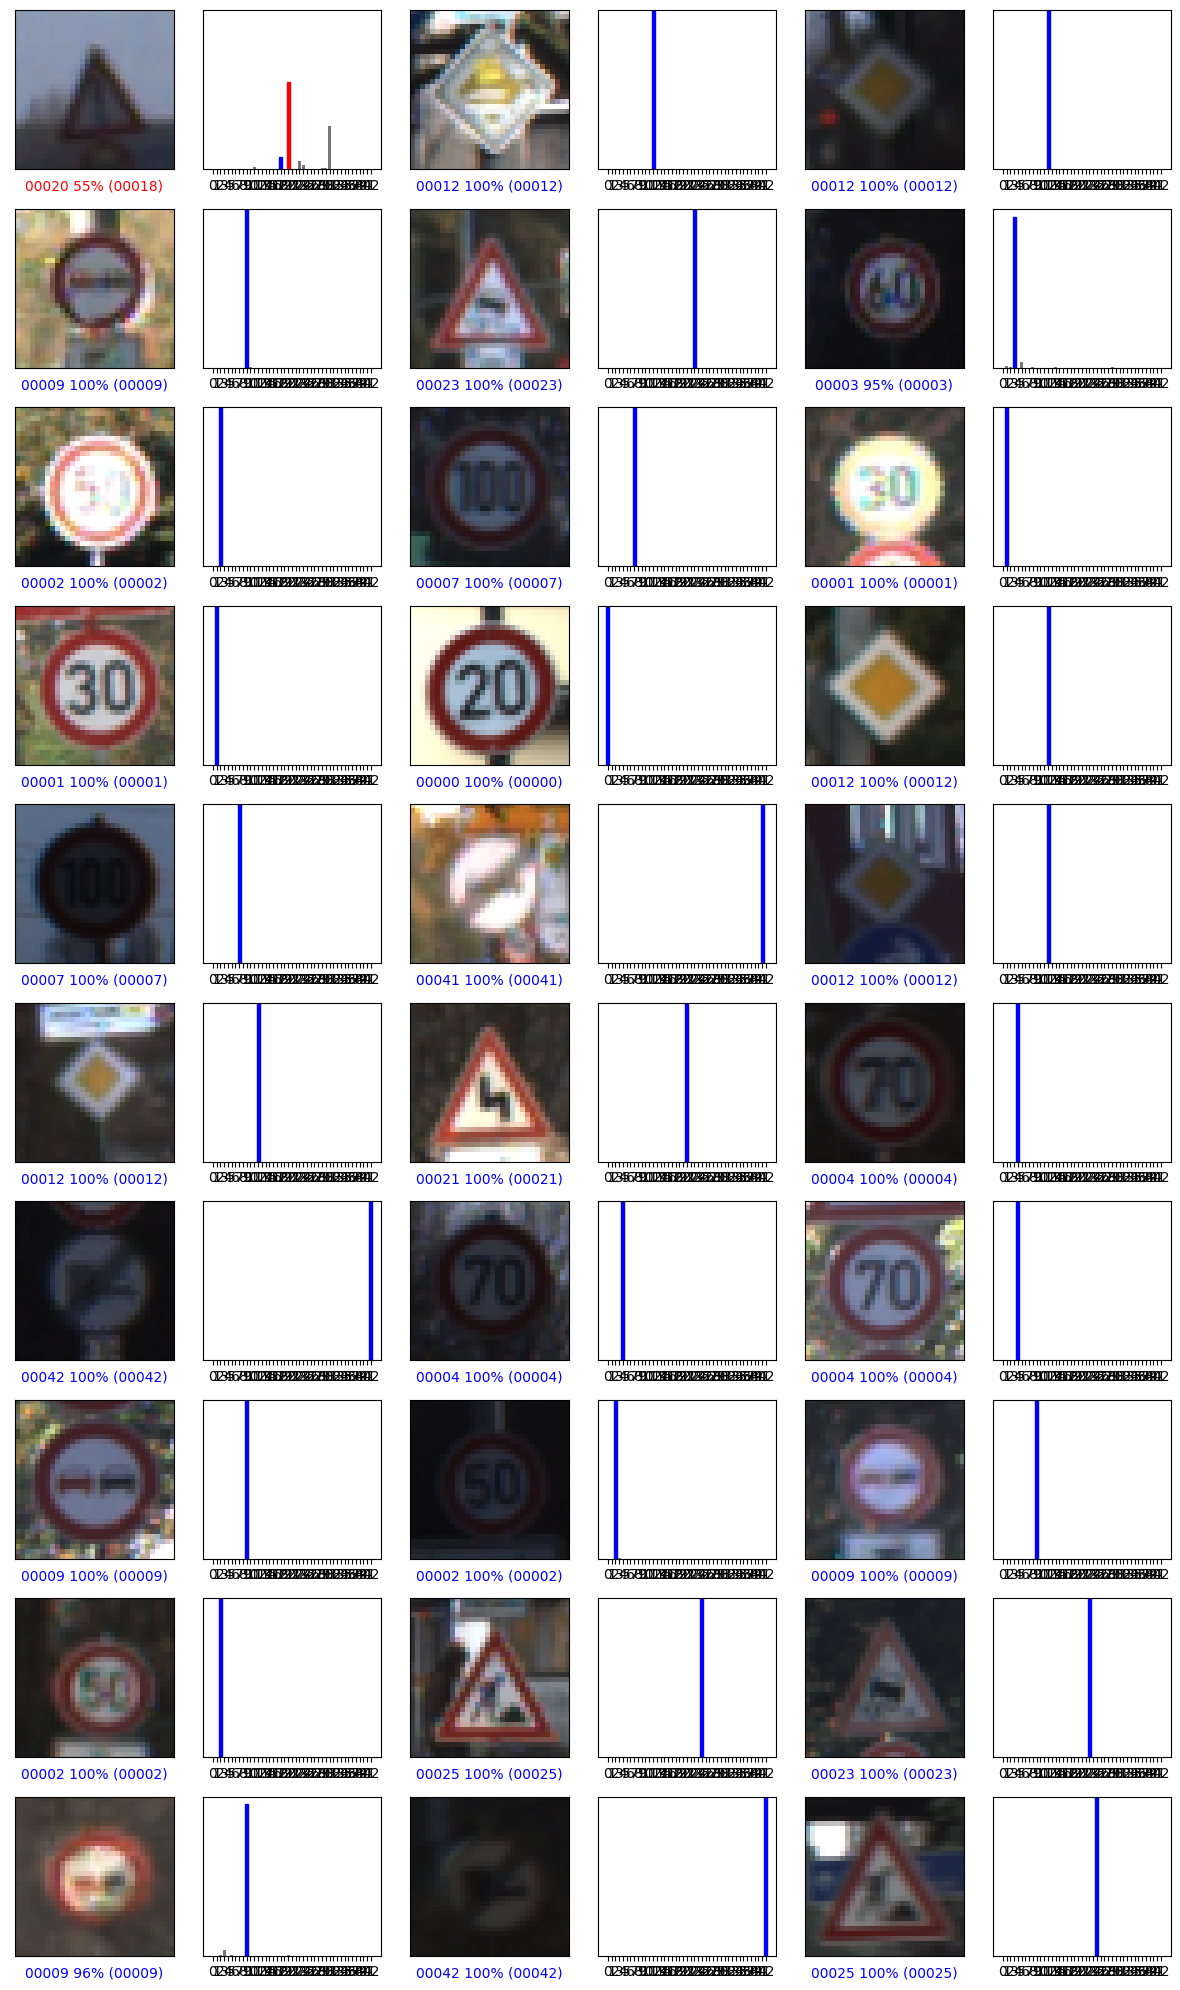

In [ ]:
images, targets = next(iter(test_loader))
logits = model_I_augmented(images.to(DEVICE))

predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
vcpi_util.plot_predictions(images, predictions, targets, train_augmented, 10, 3)

# Lets compare the results for the Augmented and not augmented approaches in this particular CNN


In [ ]:
#Lets compare the test accuracy accuracy from the evaluation process for the two models and it history through a grah plot

#Lets create a plot with two sides, one for each approach
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
#Lets plot the accuracy of the model trained without data augmentation
axs[0].plot(history_I_noagumentation['accuracy'], label='Train')
axs[0].plot(history_I_noagumentation['val_accuracy'], label='Validation')
axs[0].plot(eval_I_noagumentation, label='Test')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Model trained without data augmentation')

#Lets plot the accuracy of the model trained with data augmentation
axs[1].plot(history_I_augmented['accuracy'], label='Train')
axs[1].plot(history_I_augmented['val_accuracy'], label='Validation')
axs[1].plot(eval_I_augmented, label='Test')

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Model trained with data augmentation')

#Lets plot the accuracy of the model trained with data augmentation
axs[2].plot(history_I_vanilla['accuracy'], label='Train')
axs[2].plot(history_I_vanilla['val_accuracy'], label='Validation')
axs[2].plot(eval_I_vanilla, label='Test')

axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Model trained with original data(No transformations)')

plt.show()

---

---

In [ ]:
# Lest experiment with another Network
#TODO: Experimentar com RGB 2 Gray
model_II_noaugmentation = Conv_II(len(train_noaugmentation)).to(DEVICE)
optimizer_II = torch.optim.Adam(model_II_noaugmentation.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_II, mode='min', factor=0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()
early_stopping = Early_Stopping(9)
model_II_CNN_summary = torchinfo.summary(model_II_noaugmentation, input_size=(BATCH_SIZE, 3, img_size, img_size))

#Vamos ver a arquitetura da rede
print(model_II_CNN_summary)

In [ ]:
history_II_noaugment = train(DEVICE, model_II_noaugmentation, train_noaugmentation, train_noaugmentation_sub_loader, val_sub, val_sub_loader, EPOCHS, loss_fn, optimizer_II, scheduler, early_stopping, "model_II_noaugmentation", "model_II_noaugmentation")
torch.save(model_II_noaugmentation.state_dict(), f"models/model_II_noaugmentation/model_II_noaugmentation_best.pth")

In [ ]:
#Vamos avaliar o modelo
best_train_II_noaugment = np.asarray(history_II_noaugment['accuracy']).argmax()
best_val_II_noaugment = np.asarray(history_II_noaugment['val_accuracy']).argmax()
print(f"Best train accuracy: {history_II_noaugment['accuracy'][best_train_II_noaugment]}")
print(f"Best val accuracy: {history_II_noaugment['val_accuracy'][best_val_II_noaugment]}")

In [ ]:
eval_II_noagumentation = evaluate(model_II_noaugmentation, test_loader, DEVICE)
print(eval_II_noagumentation)

---

---

In [ ]:
#Vamos agora testar o modelo com data augmentation
model_II_augmented = Conv_II(len(train_augmented)).to(DEVICE)
optimizer_II = torch.optim.Adam(model_II_augmented.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_II, mode='min', factor=0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()
early_stopping = Early_Stopping(9)

In [ ]:
#Vamos treinar o modelo
history_II_augmented = train(DEVICE, model_II_augmented, train_augmented, train_augmented_loader, val_sub, val_sub_loader, EPOCHS, loss_fn, optimizer_II, scheduler, early_stopping, "model_II_augmented", "model_II_augmented")
torch.save(model_II_augmented.state_dict(), f"models/model_II_augmented/model_II_augmented_best.pth")

In [ ]:
#Vamos avaliar o modelo
best_train_II_augmented = np.asarray(history_II_augmented['accuracy']).argmax()
best_val_II_augmented = np.asarray(history_II_augmented['val_accuracy']).argmax()
print(f"Best train accuracy: {history_II_augmented['accuracy'][best_train_II_augmented]}")
print(f"Best val accuracy: {history_II_augmented['val_accuracy'][best_val_II_augmented]}")


In [ ]:
eval_II_augmented = evaluate(model_II_augmented, test_loader, DEVICE)
print(eval_II_augmented)

In [ ]:
#Lets compare the test accuracy accuracy from the evaluation process for the two models and it history through a grah plot

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
#Lets plot the accuracy of the model trained without data augmentation
axs[0].plot(history_II_noaugment['accuracy'], label='Train')
axs[0].plot(history_II_noaugment['val_accuracy'], label='Validation')
axs[0].plot(eval_II_noagumentation, label='Test')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Model trained without data augmentation')

#Lets plot the accuracy of the model trained with data augmentation
axs[1].plot(history_II_augmented['accuracy'], label='Train')
axs[1].plot(history_II_augmented['val_accuracy'], label='Validation')
axs[1].plot(eval_II_augmented, label='Test')

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Model trained with data augmentation')

plt.show()

# Vamos utilizar transfer learning de forma a aferirmos o resultado

In [ ]:
modelImagenet = torchvision.models.vgg16(weights = torchvision.models.VGG16_Weights.IMAGENET1K_V1)
modelVGG = torchvision.models.vgg16()
#Vamos utilizar a mobilenet que é uma rede mais simples/rápida para uma possível utilização em carros por exemplo
modelMobileNet = torchvision.models.mobilenet_v2()
eficientNet = torchvision.models.EfficientNet_V2_M_Weights()
#Vamos ver o sumário das redes

In [ ]:
summary(modelImagenet, (3, 224, 224))

In [ ]:
summary(modelVGG, (3, 224, 224))

In [ ]:
summary(modelMobileNet, (3, 224, 224))

In [ ]:
#Vamos congelar todos os parâmetros de cada rede
for param in modelImagenet.parameters():
    param.requires_grad = False

for param in modelVGG.parameters():
    param.requires_grad = False

for param in modelMobileNet.parameters():
    param.requires_grad = False

for param in eficientNet.parameters():
    param.requires_grad = False

nInputsImagenet = modelImagenet.classifier[0].in_features
nInputsVGG = modelVGG.classifier[0].in_features
nInputsMobileNet = modelMobileNet.classifier[1].in_features
nInputsEfficientNet = eficientNet.classifier[1].in_features

#Vamos adicionar um classificador ao final de cada rede
modelImagenet.classifier = torch.nn.Sequential(
    torch.nn.Linear(nInputsImagenet, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, len(train_noaugmentation))
)

modelVGG.classifier = torch.nn.Sequential(
    torch.nn.Linear(nInputsVGG, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, len(train_noaugmentation))
)

modelMobileNet.classifier = torch.nn.Sequential(
    torch.nn.Linear(nInputsMobileNet, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, len(train_noaugmentation))
)

eficientNet.classifier = torch.nn.Sequential(
    torch.nn.Linear(nInputsEfficientNet, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, len(train_noaugmentation))
)

In [ ]:
modelImagenet.to(DEVICE)
#Vamos agora testar o modelo com data augmentation
optimizer_ImageNet = torch.optim.Adam(modelImagenet.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ImageNet, mode='min', factor=0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()
early_stopping = Early_Stopping(9)

#Vamos treinar o modelo
historyImageNet = train(DEVICE, modelImagenet, train_noaugmentation_sub, train_noaugmentation_sub_loader, val_sub, val_sub_loader, EPOCHS, loss_fn, optimizer_II, scheduler, early_stopping, "model_ImageNet", "model_ImageNet")
torch.save(modelImagenet.state_dict(), f"models/model_ImageNet/model_ImageNet_best.pth")

In [ ]:
#Vamos avaliar o modelo
best_train_ImageNet = np.asarray(historyImageNet['accuracy']).argmax()
best_val_ImageNet = np.asarray(historyImageNet['val_accuracy']).argmax()
print(f"Best train accuracy: {historyImageNet['accuracy'][best_train_ImageNet]}")
print(f"Best val accuracy: {historyImageNet['val_accuracy'][best_val_ImageNet]}")

eval_ImageNet = evaluate(modelImagenet, test_loader, DEVICE)
print(eval_ImageNet)

In [2]:
modelImagenetAugmented = modelImagenet
modelImagenetAugmented.to(DEVICE)
#Vamos agora testar o modelo com data augmentation
optimizer_ImageNetAugmented = torch.optim.Adam(modelImagenetAugmented.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ImageNetAugmented, mode='min', factor=0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()
early_stopping = Early_Stopping(9)

#Vamos treinar o modelo
historyImageNetAugmented = train(DEVICE, modelImagenetAugmented, train_augmented, train_augmented_loader, val_sub, val_sub_loader, EPOCHS, loss_fn, optimizer_II, scheduler, early_stopping, "model_ImageNet_augmented", "model_ImageNet_augmented")
torch.save(modelImagenet.state_dict(), f"models/model_ImageNet_augmented/model_ImageNet_augmented_best.pth")

NameError: name 'modelImagenet' is not defined

In [ ]:
#Vamos avaliar o modelo
best_train_ImageNet_augmented = np.asarray(historyImageNetAugmented['accuracy']).argmax()
best_val_ImageNet_augmented = np.asarray(historyImageNetAugmented['val_accuracy']).argmax()
print(f"Best train accuracy: {historyImageNet['accuracy'][best_train_ImageNet_augmented]}")
print(f"Best val accuracy: {historyImageNet['val_accuracy'][best_val_ImageNet_augmented]}")

eval_ImageNet_augmented = evaluate(modelImagenetAugmented, test_loader, DEVICE)
print(eval_ImageNet_augmented)

# Fase II


Utilização de ensembles para melhorar os resultados
Até então os nossos melhores resultados foram: Fazer tabela

Para esta secção vamos utilizar duas técnicas distintas de forma a tentarmos atingir os melhores resultados, vamos utilizar soft voting e hard voting. 

Hard voting consiste em realizar a média dos votos e o resultado mais votado será o eleito.

Já no soft voting, o modelo com mais precisão originalmente será o modelo com "maior" voto